# Creación y entrenamiento de algoritmos de detención para ETA

Se entrenaran los 2 algoritmos necesarios para el funcionamiento correcto de ETA. Estos deben ser un clasificador de detención (k-means) y un estimador de tiempo de detención (XGb).

En primera instancia se muestra el entrenamiento individual por cada uno de los Origenes y Destinos existentes, luego de ello se muestra la solución final, la cual es entrenar todos los O-D en conjunto, ya que no existe una pérdida de precisión en ellos.

En este notebook ud. verá:


1. Entrenamiento para todos los OD juntos.
    * Entrenamiento de K-means
    * Entrenamiento de X-GB

In [1]:
!pip install --upgrade pip
!pip install xgboost==0.90
!pip install -U scikit-learn==0.22.1

  Using cached https://files.pythonhosted.org/packages/cd/82/04e9aaf603fdbaecb4323b9e723f13c92c245f6ab2902195c53987848c78/pip-21.1.2-py3-none-any.whl
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Using cached xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl (142.8 MB)
  Using cached scikit_learn-0.22.1-cp36-cp36m-manylinux1_x86_64.whl (7.0 MB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.20.4
    Uninstalling scikit-learn-0.20.4:
      Successfully uninstalled scikit-learn-0.20.4


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [3]:
import sklearn as sk
print(sk.__version__)

0.22.1


---
# Entremaiento para todos los OD

## Entrenamiento de K-means

__En caso de no tener un csv con todos los OD concatenados seguir los siguientes pasos__

```
od = ['CS-AN','CS-TO','NV-CS','SA-CS','SA-SDC','SA-TO']
df_concat = None
for i in od:
    df = pd.read_csv('/root/migtra.ml.eta/eta_ml/csv/paradas_'+i+'_new_limits_v1.csv').drop('Unnamed: 0',axis=1)
    df['time [min]'] = df['time [min]'].round(0)
    if i == od[0]:
        df_concat = df
    else:
        df_concat = pd.concat([df_concat, df],axis=0)
```

In [4]:
df_concat = pd.read_csv('csv_to_train/paradas-all-20200101-20210630.csv')
df_concat['time_s'] = df_concat['time [min]']*60
df_concat

Unnamed: 0     Id  time [min]  distance_km   latitude  longitude  \
0                6   9998   26.000000           17 -23.100150 -70.446200   
1                7   9998   56.000000           19 -23.105100 -70.433875   
2                8   9998  563.000000          206 -22.340275 -69.663107   
3                9   9998  571.000000          208 -22.339945 -69.663190   
4               11  18465  616.000000           66 -23.583200 -70.381308   
...            ...    ...         ...          ...        ...        ...   
111304        4621  52981  534.866667          125 -23.342780 -69.790718   
111305        4626  52999  684.333333          124 -23.343524 -69.790920   
111306        4630  53001  531.800000          115 -23.351856 -69.874811   
111307        4633  53280   95.400000          125 -23.342619 -69.790773   
111308        4636  53321   23.383333          146 -23.183300 -69.634375   

        hour   wait_s   time_s  
0         21   1560.0   1560.0  
1         21   3360.0   3360.0  
2          2  33780.0  33780.0  
3          3  34260.0  34260.0  
4         22  36960.0  36960.0  
...      ...      ...      ...  
111304    20  32092.0  32092.0  
111305    20  41060.0  41060.0  
111306    20  31908.0  31908.0  
111307    14   5724.0   5724.0  
111308    14   1403.0   1403.0  

[111309 rows x 9 columns]

In [5]:
df_concat['time_s'] = df_concat['time [min]']*60
df_concat

Unnamed: 0     Id  time [min]  distance_km   latitude  longitude  \
0                6   9998   26.000000           17 -23.100150 -70.446200   
1                7   9998   56.000000           19 -23.105100 -70.433875   
2                8   9998  563.000000          206 -22.340275 -69.663107   
3                9   9998  571.000000          208 -22.339945 -69.663190   
4               11  18465  616.000000           66 -23.583200 -70.381308   
...            ...    ...         ...          ...        ...        ...   
111304        4621  52981  534.866667          125 -23.342780 -69.790718   
111305        4626  52999  684.333333          124 -23.343524 -69.790920   
111306        4630  53001  531.800000          115 -23.351856 -69.874811   
111307        4633  53280   95.400000          125 -23.342619 -69.790773   
111308        4636  53321   23.383333          146 -23.183300 -69.634375   

        hour   wait_s   time_s  
0         21   1560.0   1560.0  
1         21   3360.0   3360.0  
2          2  33780.0  33780.0  
3          3  34260.0  34260.0  
4         22  36960.0  36960.0  
...      ...      ...      ...  
111304    20  32092.0  32092.0  
111305    20  41060.0  41060.0  
111306    20  31908.0  31908.0  
111307    14   5724.0   5724.0  
111308    14   1403.0   1403.0  

[111309 rows x 9 columns]

<AxesSubplot:>

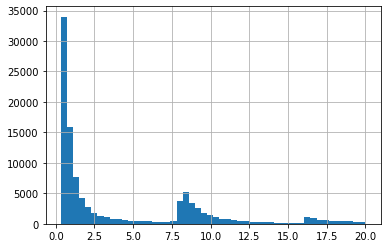

In [6]:
aux = df_concat[df_concat['time_s']<20*3600]
time  = aux.time_s/3600
time.hist(bins=50)

Es importante explorar si existen más de 2 grupos de detenciones, lo esperable es que existan grupos de detención corta (menor a 3 horas) y detenciones largas superiores a 3 horas pero menores a 16 hrs, ya que más de eso excede el tiempo de sueño y pertenece a fallas en los vehículos

In [7]:
df_concat = df_concat[df_concat['time_s']<16*3600]
df_concat

Unnamed: 0     Id  time [min]  distance_km   latitude  longitude  \
0                6   9998   26.000000           17 -23.100150 -70.446200   
1                7   9998   56.000000           19 -23.105100 -70.433875   
2                8   9998  563.000000          206 -22.340275 -69.663107   
3                9   9998  571.000000          208 -22.339945 -69.663190   
4               11  18465  616.000000           66 -23.583200 -70.381308   
...            ...    ...         ...          ...        ...        ...   
111304        4621  52981  534.866667          125 -23.342780 -69.790718   
111305        4626  52999  684.333333          124 -23.343524 -69.790920   
111306        4630  53001  531.800000          115 -23.351856 -69.874811   
111307        4633  53280   95.400000          125 -23.342619 -69.790773   
111308        4636  53321   23.383333          146 -23.183300 -69.634375   

        hour   wait_s   time_s  
0         21   1560.0   1560.0  
1         21   3360.0   3360.0  
2          2  33780.0  33780.0  
3          3  34260.0  34260.0  
4         22  36960.0  36960.0  
...      ...      ...      ...  
111304    20  32092.0  32092.0  
111305    20  41060.0  41060.0  
111306    20  31908.0  31908.0  
111307    14   5724.0   5724.0  
111308    14   1403.0   1403.0  

[98734 rows x 9 columns]

<AxesSubplot:>

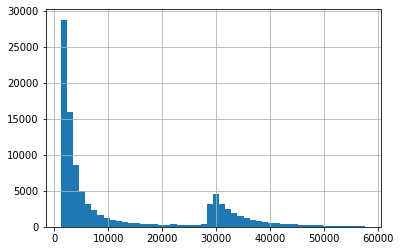

In [8]:
df_concat.time_s.hist(bins=50)

__opcional: guardar una versión del dataset.__

In [9]:
#guardamos el dataset
# df_concat.to_csv('csv_to_train/paradas-all-20200101-20210630_filtered.csv',index=False)
df_concat = pd.read_csv('csv_to_train/paradas-all-20200101-20210630_filtered.csv')
df_concat

Unnamed: 0     Id  time [min]  distance_km   latitude  longitude  hour  \
0               6   9998   26.000000           17 -23.100150 -70.446200    21   
1               7   9998   56.000000           19 -23.105100 -70.433875    21   
2               8   9998  563.000000          206 -22.340275 -69.663107     2   
3               9   9998  571.000000          208 -22.339945 -69.663190     3   
4              11  18465  616.000000           66 -23.583200 -70.381308    22   
...           ...    ...         ...          ...        ...        ...   ...   
98729        4621  52981  534.866667          125 -23.342780 -69.790718    20   
98730        4626  52999  684.333333          124 -23.343524 -69.790920    20   
98731        4630  53001  531.800000          115 -23.351856 -69.874811    20   
98732        4633  53280   95.400000          125 -23.342619 -69.790773    14   
98733        4636  53321   23.383333          146 -23.183300 -69.634375    14   

        wait_s   time_s  
0       1560.0   1560.0  
1       3360.0   3360.0  
2      33780.0  33780.0  
3      34260.0  34260.0  
4      36960.0  36960.0  
...        ...      ...  
98729  32092.0  32092.0  
98730  41060.0  41060.0  
98731  31908.0  31908.0  
98732   5724.0   5724.0  
98733   1403.0   1403.0  

[98734 rows x 9 columns]

In [10]:
x = df_concat.loc[:,['time [min]','distance_km','hour']].values
x

array([[ 26.        ,  17.        ,  21.        ],
       [ 56.        ,  19.        ,  21.        ],
       [563.        , 206.        ,   2.        ],
       ...,
       [531.8       , 115.        ,  20.        ],
       [ 95.4       , 125.        ,  14.        ],
       [ 23.38333333, 146.        ,  14.        ]])

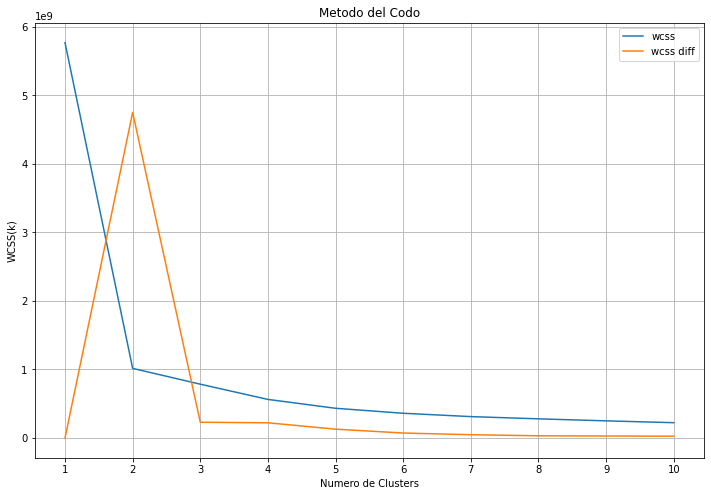

In [11]:
# ##Metodo del Codo para Optimizar el N de clusters

wcss = []  #puntos del codo
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init="k-means++",max_iter=300,n_init=10,random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_) ## esto calcula la suma de los cuadradados de la dif

#dif pesos
wcss_diff = []
previus = 0
for i in wcss:
    if i == wcss[0]:
        wcss_diff.append(0)
        previus = i
    else:
        wcss_diff.append(previus-i)
        previus = i
wcss_diff    
    
plt.figure(figsize=(12,8))
plt.plot(range(1,11),wcss, label='wcss')
plt.plot(range(1,11),wcss_diff,label='wcss diff')
plt.legend()
plt.title("Metodo del Codo")
plt.xlabel("Numero de Clusters")
plt.ylabel("WCSS(k)")
plt.xticks(np.arange(1,11,1))
plt.grid(True)
plt.show()

In [12]:
kmeans = KMeans(n_clusters=2,init="k-means++",max_iter=300,n_init=10,random_state=0)
y_kmeans = kmeans.fit_predict(x)

In [13]:
df_concat = df_concat.assign(clasificacion=y_kmeans)
df_concat.tail()

Unnamed: 0     Id  time [min]  distance_km   latitude  longitude  hour  \
98729        4621  52981  534.866667          125 -23.342780 -69.790718    20   
98730        4626  52999  684.333333          124 -23.343524 -69.790920    20   
98731        4630  53001  531.800000          115 -23.351856 -69.874811    20   
98732        4633  53280   95.400000          125 -23.342619 -69.790773    14   
98733        4636  53321   23.383333          146 -23.183300 -69.634375    14   

        wait_s   time_s  clasificacion  
98729  32092.0  32092.0              0  
98730  41060.0  41060.0              0  
98731  31908.0  31908.0              0  
98732   5724.0   5724.0              1  
98733   1403.0   1403.0              1

Clasificacion del Kmeans

1. Valor 1 para detenciones largas
2. Valor 0 para detenciones cortas

## Guardamos el modelo

In [15]:
import mxnet as mx

centroids = mx.ndarray.array(kmeans.cluster_centers_)
file_name = 'eta-retorno-stops-kmeans-v1'
file_output = 'eta-retorno-stops-kmeans-v1.tar.gz'
mx.ndarray.save(file_name, [centroids])
print(centroids)


[[557.0673   126.53274   15.406869]
 [ 65.60906  116.40256   13.870174]]
<NDArray 2x3 @cpu(0)>


In [16]:
!tar czvf $file_output $file_name

eta-retorno-stops-kmeans-v1


In [29]:
# Define IAM role
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
import os

role = get_execution_role()
bucket = 'migtra.ai.dev'
local_path = '/root/eta-retorno/models'
name_in_s3 = 'models-eta-retorno/eta-retorno-stops-kmeans-v1.tar.gz'

s3 = boto3.resource('s3')
s3.meta.client.upload_file(os.path.join(local_path, 'eta-retorno-stops-kmeans-v1.tar.gz'), bucket, name_in_s3)

## Entrenamiento de X-GB

Una vez que hemos creado el modelo de K-means para entender si la detención pertenece a una larga o corta es momento de estimar cuanto tiempo va a estar detenido a partir de la información entregada por el kmeans.

In [17]:
df_concat

Unnamed: 0     Id  time [min]  distance_km   latitude  longitude  hour  \
0               6   9998   26.000000           17 -23.100150 -70.446200    21   
1               7   9998   56.000000           19 -23.105100 -70.433875    21   
2               8   9998  563.000000          206 -22.340275 -69.663107     2   
3               9   9998  571.000000          208 -22.339945 -69.663190     3   
4              11  18465  616.000000           66 -23.583200 -70.381308    22   
...           ...    ...         ...          ...        ...        ...   ...   
98729        4621  52981  534.866667          125 -23.342780 -69.790718    20   
98730        4626  52999  684.333333          124 -23.343524 -69.790920    20   
98731        4630  53001  531.800000          115 -23.351856 -69.874811    20   
98732        4633  53280   95.400000          125 -23.342619 -69.790773    14   
98733        4636  53321   23.383333          146 -23.183300 -69.634375    14   

        wait_s   time_s  clasificacion  
0       1560.0   1560.0              1  
1       3360.0   3360.0              1  
2      33780.0  33780.0              0  
3      34260.0  34260.0              0  
4      36960.0  36960.0              0  
...        ...      ...            ...  
98729  32092.0  32092.0              0  
98730  41060.0  41060.0              0  
98731  31908.0  31908.0              0  
98732   5724.0   5724.0              1  
98733   1403.0   1403.0              1  

[98734 rows x 10 columns]

In [18]:
df_concat['time min'] = df_concat['time [min]'].round(0)
df_concat['distance_km'] = df_concat['distance_km'].round(0)
x = df_concat.loc[:,['distance_km','latitude','longitude','hour','clasificacion']]
y = df_concat.loc[:,['time min']]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 0)

[00:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 del modelo:  0.9248906331516905


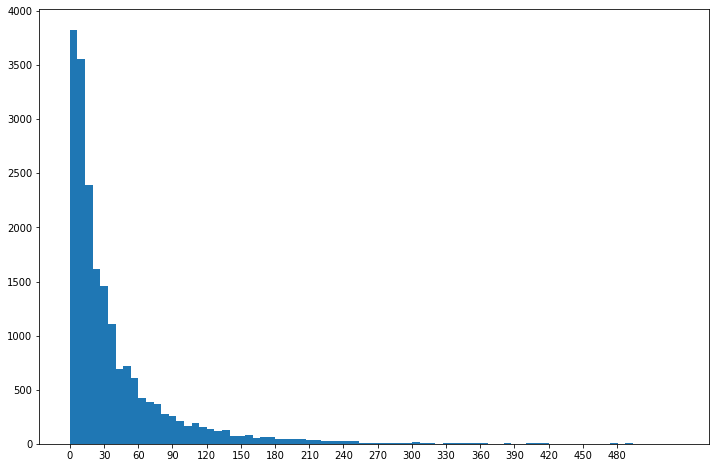

In [19]:
#Creamos el modelo
estimadores = 55
splits = 12
leaf = 18
max_depth = 38
lr = 0.1
loss = 'huber'
criterio = 'friedman_mse'
objetivo = 'reg:squarederror'
m1 = xgb.XGBRegressor(n_estimators = estimadores, max_depth = max_depth, learning_rate = lr, random_state = 0)
# m1 =  xgb.XGBRegressor()
m1.fit(x_train, y_train)

print('R^2 del modelo: ',m1.score(x_test, y_test))
pred = m1.predict(x_test).round(0)
a = y_test
a = a.assign(prediction = pred )
a = a.assign(error = a['prediction']-a['time min'])

plt.figure(figsize=(12,8))
plt.hist(abs(a['error']),bins=80)
plt.xticks(np.arange(0,500,30))
plt.show()

In [20]:
print("% viajes cortos :",a[(a['time min']<300)].shape[0]/a.shape[0])
print("% viajes largos :",a[(a['time min']>300)].shape[0]/a.shape[0])

#print("% de error para tiempos menores a 20 minutos en viajes largos :",a[(a['error']<20) & (a['time min']>5*3600)].shape[0]/a[(a['time min']>5*3600)].shape[0])
#print("% de error para tiempos menores a 20 minutos en viajes cortos :",a[(a['error']<20) & (a['time min']<5*3600)].shape[0]/a[(a['time min']<5*3600)].shape[0])

% viajes cortos : 0.7199574618929457
% viajes largos : 0.27978933508887427


In [21]:
x_test

distance_km   latitude  longitude  hour  clasificacion
68410           49 -22.080517 -69.593422     0              0
32592          129 -23.342974 -69.790964    12              0
55126          109 -21.629348 -69.550169    19              1
65336          126 -23.342995 -69.791329    15              1
47851          114 -21.627397 -69.550580     1              0
...            ...        ...        ...   ...            ...
23393          208 -23.342637 -69.791256    11              1
58494          185 -23.339100 -69.746900    10              1
49384          109 -22.442154 -68.898767     3              0
36435          153 -21.630375 -69.549805    16              1
33553          147 -23.342274 -69.790795    15              1

[19747 rows x 5 columns]

In [22]:
a

time min  prediction  error
68410     500.0       525.0   25.0
32592     434.0       379.0  -55.0
55126      27.0        30.0    3.0
65336      51.0        50.0   -1.0
47851     501.0       517.0   16.0
...         ...         ...    ...
23393      59.0        91.0   32.0
58494      42.0        39.0   -3.0
49384     477.0       608.0  131.0
36435      90.0        63.0  -27.0
33553      27.0       133.0  106.0

[19747 rows x 3 columns]

In [25]:
model_file_name = 'eta-retorno-stops-xgb-v1'
model_file_output = model_file_name + '.tar.gz' 
m1._Booster.save_model(model_file_name)

In [26]:
!tar czvf $model_file_output $model_file_name

eta-retorno-stops-xgb-v1


In [24]:
# Define IAM role
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
import os

role = get_execution_role()
bucket = 'migtra.ai.dev'
local_path = '/root/eta-retorno/models'
name_in_s3 = 'models-eta-retorno/eta-retorno-stops-xgb-v1.tar.gz'

s3 = boto3.resource('s3')
s3.meta.client.upload_file(os.path.join(local_path, 'eta-retorno-stops-xgb-v1.tar.gz'), bucket, name_in_s3)

## Para guardar los modelos en versión picle

In [27]:
!pip install joblib
import joblib
version = 'v1'
joblib.dump(m1, '/root/eta-retorno/models/eta-retorno-stops-xgb-'+version+'.pkl')
joblib.dump(kmeans,'/root/eta-retorno/models/eta-retorno-stops-kmeans-'+version+'.pkl')

['/root/eta-retorno/models/eta-retorno-stops-kmeans-v1.pkl']

__De esta forma finalizamos con 3 archivos de modelo para cada modelo, es decir 3 distnitnos formatos para kmeans y 3 para xgb__